Setting up the environment and verifying GPU availability is the focus here. I start by importing core libraries for timing and system operations, then use the `pip_install()` function to quietly install all required packages, keeping the output clean.

After installation, I verify the GPU setup using PyTorch's CUDA detection, which is crucial since training transformer models without a GPU would take far too long. The code prints detailed information about the GPU name, CUDA version, and memory capacity, confirming everything is ready. Tracking the setup time also helps me understand the total runtime later when analyzing efficiency.

In [1]:
# CELL 1: Environment Setup & GPU Check
import sys, subprocess, torch, platform, warnings, time
warnings.filterwarnings('ignore')

cell_start = time.time()

def pip_install(packages):
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q"] + packages)

print("Installing packages...")
pip_install(["transformers>=4.44.0", "datasets>=2.14.0", "accelerate>=0.26.0",
             "evaluate>=0.4.0", "scikit-learn>=1.3.0", "matplotlib>=3.7.0",
             "seaborn>=0.12.0", "openpyxl"])

# GPU verification
print("\n" + "="*70)
print("ENVIRONMENT & GPU CHECK")
print("="*70)
print(f"Python: {sys.version.split()[0]} | PyTorch: {torch.__version__}")
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"GPU: {torch.cuda.get_device_name(0)} | CUDA: {torch.version.cuda}")
    print(f"GPU Memory: {round(torch.cuda.get_device_properties(0).total_memory / 1024**3, 2)} GB")
else:
    device = torch.device("cpu")
    print("WARNING: No GPU detected")
print("="*70)

cell_time = round(time.time() - cell_start, 2)
print(f"\nCell 1 runtime: {cell_time}s ({cell_time/60:.1f} min)")

Installing packages...

ENVIRONMENT & GPU CHECK
Python: 3.12.12 | PyTorch: 2.8.0+cu126
GPU: Tesla T4 | CUDA: 12.6
GPU Memory: 14.74 GB

Cell 1 runtime: 6.2s (0.1 min)


Dataset upload and splitting happens here. Since I'm working in Google Colab, I use `files.upload()` to prompt for the CSV file upload directly from my local machine. Once uploaded, pandas reads the CSV into a DataFrame so I can explore it easily by checking size and column names.

The cleaning step removes any rows with missing questions or answers, ensuring data completeness. For the train-validation split, I use an 85/15 ratio with a fixed random seed for reproducibility. Shuffling the data before splitting helps prevent any ordering bias that might exist in the original dataset.

In [2]:
# CELL 2: Dataset Upload, Load & Split
import pandas as pd
import numpy as np
from google.colab import files

cell_start = time.time()

# Upload
print("Upload medquadCardiovascular.csv...")
uploaded = files.upload()
CSV_PATH = list(uploaded.keys())[0]

# Load and explore
df = pd.read_csv(CSV_PATH)
print(f"\nDataset: {len(df)} rows, {len(df.columns)} columns")
print(f"Columns: {list(df.columns)}")

# Clean and split (85/15)
df_clean = df.dropna(subset=["question", "answer"]).reset_index(drop=True)
np.random.seed(42)
df_shuffled = df_clean.sample(frac=1.0, random_state=42).reset_index(drop=True)
split_idx = int(len(df_shuffled) * 0.85)

train_df = df_shuffled.iloc[:split_idx].copy()
val_df = df_shuffled.iloc[split_idx:].copy()

print(f"\nTrain: {len(train_df)} | Val: {len(val_df)}")
print(f"Sample question: {train_df.iloc[0]['question'][:80]}...")
print(f"Sample answer length: {len(train_df.iloc[0]['answer'])} chars")

cell_time = round(time.time() - cell_start, 2)
print(f"\nCell 2 runtime: {cell_time}s")

Upload medquadCardiovascular.csv...


Saving medquadCardiovascular.csv to medquadCardiovascular.csv

Dataset: 654 rows, 4 columns
Columns: ['question', 'answer', 'source', 'focus_area']

Train: 555 | Val: 99
Sample question: What causes Pulmonary Hypertension ?...
Sample answer length: 1632 chars

Cell 2 runtime: 63.48s


Defining the tokenization function is essential for preparing text data for the transformer models. The `prepare_train_features()` function takes raw question-answer pairs and converts them into token IDs that the model can process. I implemented adaptive tokenization here, which is particularly important because BioBERT is cased while BlueBERT is not.

The function detects whether the tokenizer uses lowercasing, and if it doesn't, it performs case-insensitive matching when finding answer positions in the context. Without this, BioBERT might miss answers due to capitalization differences. The tokenizer handles long contexts by using a sliding window approach with `doc_stride`, and I search for the answer by comparing the first few words against token spans.

I chose this heuristic approach because it works well for question-answering tasks where the answer is embedded in a longer context. The function carefully tracks start and end positions for each answer span, which the model will learn to predict during training.

In [3]:
# CELL 3: Adaptive Tokenization Function
cell_start = time.time()

MAX_LENGTH = 384
DOC_STRIDE = 128

def prepare_train_features(examples, tokenizer):
    """Adaptive tokenization with case-insensitive answer detection for cased models"""
    is_cased = not getattr(tokenizer, 'do_lower_case', False)

    tokenized = tokenizer(
        examples["question"],
        examples["answer"],
        truncation="only_second",
        max_length=MAX_LENGTH,
        stride=DOC_STRIDE,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding="max_length",
    )

    start_positions = []
    end_positions = []

    for i, offsets in enumerate(tokenized["offset_mapping"]):
        sequence_ids = tokenized.sequence_ids(i)
        sample_idx = tokenized["overflow_to_sample_mapping"][i] if "overflow_to_sample_mapping" in tokenized else i
        answer_text = examples["answer"][sample_idx] if isinstance(examples["answer"], list) else examples["answer"]

        # Find context boundaries
        context_start = context_end = None
        for idx, seq_id in enumerate(sequence_ids):
            if seq_id == 1:
                if context_start is None:
                    context_start = idx
                context_end = idx

        if context_start is None or not answer_text:
            start_positions.append(0)
            end_positions.append(0)
        else:
            # Extract first 3 words for matching
            answer_words = answer_text.strip().split()[:3]
            search_text = " ".join(answer_words)
            search_text_lower = search_text.lower() if is_cased else search_text

            # Find best token span
            best_match_idx = context_start
            best_match_score = 0

            for start_idx in range(context_start, min(context_start + 20, context_end)):
                token_span = tokenizer.decode(tokenized["input_ids"][i][start_idx:min(start_idx + 10, context_end)])
                token_span_lower = token_span.lower() if is_cased else token_span

                if search_text_lower in token_span_lower:
                    match_score = len(search_text_lower)
                    if match_score > best_match_score:
                        best_match_score = match_score
                        best_match_idx = start_idx

            answer_start = best_match_idx
            span_length = min(max(30, len(answer_text.split()) // 2), 80)
            answer_end = min(answer_start + span_length, context_end)

            start_positions.append(answer_start)
            end_positions.append(answer_end)

    tokenized["start_positions"] = start_positions
    tokenized["end_positions"] = end_positions
    if "offset_mapping" in tokenized:
        tokenized.pop("offset_mapping")

    return tokenized

cell_time = round(time.time() - cell_start, 2)
print(f"Tokenization function ready | Cell 3 runtime: {cell_time}s")

Tokenization function ready | Cell 3 runtime: 0.0s


Creating the metrics computation function helps evaluate model performance accurately. The `compute_qa_metrics()` function calculates several important scores that assess how well the model answers questions. I extract predicted start and end positions from the model's logits and compare them against the true positions.

Exact match is the strictest metric, requiring both boundaries to be perfect. For F1, precision, and recall, I treat the answer span as a set of token positions and calculate overlap between predicted and true spans. The composite accuracy metric averages exact match with start and end accuracies, providing a balanced view of performance. I handle edge cases where predictions or ground truth are empty to avoid division by zero errors.

In [4]:
# CELL 4: Metrics Computation Function
cell_start = time.time()

def compute_qa_metrics(eval_pred):
    """Compute F1, Precision, Recall, Accuracy, Exact Match"""
    predictions, label_ids = eval_pred
    start_logits, end_logits = predictions

    pred_starts = np.argmax(start_logits, axis=1)
    pred_ends = np.argmax(end_logits, axis=1)
    true_starts = np.asarray(label_ids[0]).reshape(-1)
    true_ends = np.asarray(label_ids[1]).reshape(-1)

    exact_match = np.mean((pred_starts == true_starts) & (pred_ends == true_ends))
    start_accuracy = np.mean(pred_starts == true_starts)
    end_accuracy = np.mean(pred_ends == true_ends)

    f1_scores = []
    precision_scores = []
    recall_scores = []

    for ps, pe, ts, te in zip(pred_starts, pred_ends, true_starts, true_ends):
        ps, pe, ts, te = int(ps), int(pe), int(ts), int(te)
        pred_tokens = set(range(ps, pe + 1))
        true_tokens = set(range(ts, te + 1))

        if not pred_tokens and not true_tokens:
            f1_scores.append(1.0)
            precision_scores.append(1.0)
            recall_scores.append(1.0)
        elif not pred_tokens or not true_tokens:
            f1_scores.append(0.0)
            precision_scores.append(0.0)
            recall_scores.append(0.0)
        else:
            common = len(pred_tokens & true_tokens)
            if common == 0:
                f1_scores.append(0.0)
                precision_scores.append(0.0)
                recall_scores.append(0.0)
            else:
                precision = common / len(pred_tokens)
                recall = common / len(true_tokens)
                precision_scores.append(precision)
                recall_scores.append(recall)
                f1_scores.append(2 * (precision * recall) / (precision + recall))

    accuracy = (exact_match + start_accuracy + end_accuracy) / 3

    return {
        "accuracy": float(accuracy),
        "exact_match": float(exact_match),
        "f1": float(np.mean(f1_scores)) if f1_scores else 0.0,
        "precision": float(np.mean(precision_scores)) if precision_scores else 0.0,
        "recall": float(np.mean(recall_scores)) if recall_scores else 0.0,
    }

cell_time = round(time.time() - cell_start, 2)
print(f"Metrics function ready | Cell 4 runtime: {cell_time}s")

Metrics function ready | Cell 4 runtime: 0.0s


Building the training wrapper function allows me to run each trial systematically. The `train_and_evaluate()` function takes a model name, tokenizer, datasets, and hyperparameters, then trains and evaluates the model. I load the model fresh for each trial and configure the `TrainingArguments` with the specific hyperparameters being tested.

Using FP16 mixed precision speeds up training on the GPU while maintaining accuracy. The trainer handles the training loop automatically, and I track the runtime to compare efficiency across different configurations. After training completes, I evaluate on the validation set and package all results into a dictionary. Memory management matters here, so I explicitly delete the model and trainer objects and clear the GPU cache after each trial to prevent memory buildup across multiple runs.

In [5]:
# CELL 5: Training Wrapper
from transformers import AutoModelForQuestionAnswering, AutoTokenizer, Trainer, TrainingArguments, default_data_collator
from datasets import Dataset

cell_start = time.time()

def train_and_evaluate(model_name, tokenizer, train_data, val_data, hyperparams, trial_name):
    """Train and evaluate model with given hyperparameters"""
    print(f"\n{'='*70}")
    print(f"{trial_name} | Epochs={hyperparams['epochs']}, LR={hyperparams['lr']:.2e}, Batch={hyperparams['batch']}")

    model = AutoModelForQuestionAnswering.from_pretrained(model_name).to(device)

    training_args = TrainingArguments(
        output_dir=f"./temp_{trial_name}",
        num_train_epochs=hyperparams["epochs"],
        per_device_train_batch_size=hyperparams["batch"],
        per_device_eval_batch_size=hyperparams["batch"],
        gradient_accumulation_steps=hyperparams["grad_accum"],
        learning_rate=hyperparams["lr"],
        warmup_ratio=hyperparams.get("warmup", 0.1),
        weight_decay=hyperparams.get("weight_decay", 0.01),
        fp16=torch.cuda.is_available(),
        dataloader_pin_memory=True,
        dataloader_num_workers=2,
        eval_strategy="epoch",
        save_strategy="no",
        logging_steps=50,
        report_to=[],
        disable_tqdm=False,
        seed=42,
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_data,
        eval_dataset=val_data,
        tokenizer=tokenizer,
        data_collator=default_data_collator,
        compute_metrics=compute_qa_metrics,
    )

    start_time = time.time()
    trainer.train()
    runtime = round(time.time() - start_time, 2)

    eval_results = trainer.evaluate()

    results = {
        "trial": trial_name,
        "f1": eval_results.get("eval_f1", 0) * 100,
        "accuracy": eval_results.get("eval_accuracy", 0) * 100,
        "precision": eval_results.get("eval_precision", 0) * 100,
        "recall": eval_results.get("eval_recall", 0) * 100,
        "runtime": runtime,
        "hyperparams": hyperparams.copy()
    }

    print(f"Complete: F1={results['f1']:.2f}%, Acc={results['accuracy']:.2f}%, Time={runtime}s")

    del model, trainer
    torch.cuda.empty_cache()

    return results

cell_time = round(time.time() - cell_start, 2)
print(f"Training wrapper ready | Cell 5 runtime: {cell_time}s")

Training wrapper ready | Cell 5 runtime: 0.0s


Configuring the grid search space involves defining the hyperparameter combinations to test. I use `itertools.product()` to generate all possible combinations from the specified ranges, which is the essence of grid search. The search space is focused based on insights from manual experiments, concentrating on learning rates between 4e-5 and 5e-5 and epochs between 5 and 6.

I keep batch size and gradient accumulation fixed since those worked well previously, but vary the warmup ratio to see its effect. The focused approach reduces configurations from 12 to 8, saving time while still covering the most promising parameter ranges.

In [6]:
# CELL 6: Define Optimized Grid Search Space
# OPTIMIZATION: Reduced from 12 to 8 configs per method
from itertools import product

cell_start = time.time()

# Focused grid based on manual results: higher LR (4e-5, 5e-5), fewer epochs (5-6), batch 16
grid_space = {
    "lr": [4e-5, 5e-5],          # Best performers from manual
    "epochs": [5, 6],            # Optimal range
    "batch": [16],               # Fixed
    "grad_accum": [2],           # Fixed
    "warmup": [0.1, 0.15],       # Two warmup values
}

grid_configs = []
for lr, epochs, batch, accum, warmup in product(
    grid_space["lr"], grid_space["epochs"], grid_space["batch"],
    grid_space["grad_accum"], grid_space["warmup"]
):
    grid_configs.append({
        "lr": lr, "epochs": epochs, "batch": batch,
        "grad_accum": accum, "warmup": warmup, "weight_decay": 0.01
    })

print(f"Grid Search: {len(grid_configs)} configurations (optimized from 12)")
print("Focusing on best-performing ranges from manual results:")
for i, cfg in enumerate(grid_configs):
    print(f"  {i+1}. Epochs={cfg['epochs']}, LR={cfg['lr']:.2e}, Warmup={cfg['warmup']}")

cell_time = round(time.time() - cell_start, 2)
print(f"\nCell 6 runtime: {cell_time}s")

Grid Search: 8 configurations (optimized from 12)
Focusing on best-performing ranges from manual results:
  1. Epochs=5, LR=4.00e-05, Warmup=0.1
  2. Epochs=5, LR=4.00e-05, Warmup=0.15
  3. Epochs=6, LR=4.00e-05, Warmup=0.1
  4. Epochs=6, LR=4.00e-05, Warmup=0.15
  5. Epochs=5, LR=5.00e-05, Warmup=0.1
  6. Epochs=5, LR=5.00e-05, Warmup=0.15
  7. Epochs=6, LR=5.00e-05, Warmup=0.1
  8. Epochs=6, LR=5.00e-05, Warmup=0.15

Cell 6 runtime: 0.0s


Executing the grid search trials for both models starts with an important optimization. I tokenize the datasets once for each model upfront, which saves significant time since tokenization is expensive and the same tokenized data can be reused across all trials. Loading both tokenizers and converting the pandas DataFrames to Hugging Face Datasets makes them compatible with the trainer.

I loop through each grid configuration and train both BlueBERT and BioBERT with those same hyperparameters, allowing for a fair comparison. Tracking which trial achieves the best F1 score helps identify the optimal configuration. At the end, I print summary statistics including the best performers and average time per trial, giving a clear picture of grid search performance.

In [7]:
# CELL 7: Execute Grid Search (Both Models)
# OPTIMIZATION: Reduced configs
MODEL_BLUE = "aaditya/Bluebert_emrqa"
MODEL_BIO = "dmis-lab/biobert-base-cased-v1.1"

cell_start = time.time()

print("\n" + "="*70)
print("GRID SEARCH - BOTH MODELS")
print("="*70)

# Tokenize datasets once
print("\nTokenizing datasets...")
tok_start = time.time()

tokenizer_blue = AutoTokenizer.from_pretrained(MODEL_BLUE, use_fast=True)
tokenizer_bio = AutoTokenizer.from_pretrained(MODEL_BIO, use_fast=True)

train_ds = Dataset.from_pandas(train_df)
val_ds = Dataset.from_pandas(val_df)

tok_train_blue = train_ds.map(lambda x: prepare_train_features(x, tokenizer_blue), batched=True, remove_columns=train_ds.column_names)
tok_val_blue = val_ds.map(lambda x: prepare_train_features(x, tokenizer_blue), batched=True, remove_columns=val_ds.column_names)
tok_train_bio = train_ds.map(lambda x: prepare_train_features(x, tokenizer_bio), batched=True, remove_columns=train_ds.column_names)
tok_val_bio = val_ds.map(lambda x: prepare_train_features(x, tokenizer_bio), batched=True, remove_columns=val_ds.column_names)

tok_time = round(time.time() - tok_start, 2)
print(f"Tokenization complete: {tok_time}s\n")

# Execute grid search
grid_results_blue = []
grid_results_bio = []

for i, cfg in enumerate(grid_configs):
    # BlueBERT
    result = train_and_evaluate(MODEL_BLUE, tokenizer_blue, tok_train_blue, tok_val_blue,
                                cfg, f"Grid_Blue_{i+1}")
    grid_results_blue.append(result)

    # BioBERT
    result = train_and_evaluate(MODEL_BIO, tokenizer_bio, tok_train_bio, tok_val_bio,
                                cfg, f"Grid_Bio_{i+1}")
    grid_results_bio.append(result)

best_grid_blue = max(grid_results_blue, key=lambda x: x["f1"])
best_grid_bio = max(grid_results_bio, key=lambda x: x["f1"])

grid_total_time = round(time.time() - cell_start, 2)

print(f"\n{'='*70}")
print("GRID SEARCH COMPLETE")
print(f"{'='*70}")
print(f"Best Grid BlueBERT: F1={best_grid_blue['f1']:.2f}%, Time={best_grid_blue['runtime']}s")
print(f"Best Grid BioBERT: F1={best_grid_bio['f1']:.2f}%, Time={best_grid_bio['runtime']}s")
print(f"Total Grid Search Time: {grid_total_time}s ({grid_total_time/60:.1f} min)")
print(f"Average time per trial: {grid_total_time/(len(grid_configs)*2):.1f}s")


GRID SEARCH - BOTH MODELS

Tokenizing datasets...


tokenizer_config.json:   0%|          | 0.00/402 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/313 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

Map:   0%|          | 0/555 [00:00<?, ? examples/s]

Map:   0%|          | 0/99 [00:00<?, ? examples/s]

Map:   0%|          | 0/555 [00:00<?, ? examples/s]

Map:   0%|          | 0/99 [00:00<?, ? examples/s]

Tokenization complete: 13.64s


Grid_Blue_1 | Epochs=5, LR=4.00e-05, Batch=16


config.json:   0%|          | 0.00/667 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/436M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

Epoch,Training Loss,Validation Loss,Accuracy,Exact Match,F1,Precision,Recall
1,No log,1.554052,0.430976,0.146465,0.962151,0.954929,0.978596
2,5.029200,1.259557,0.437710,0.156566,0.971134,0.966989,0.981052
3,5.029200,1.218709,0.454545,0.181818,0.976139,0.970920,0.985383
4,1.264200,1.234543,0.478114,0.217172,0.979909,0.971977,0.990678
5,0.956300,1.233456,0.488215,0.232323,0.979322,0.976901,0.985226


Complete: F1=97.93%, Acc=48.82%, Time=99.94s

Grid_Bio_1 | Epochs=5, LR=4.00e-05, Batch=16


pytorch_model.bin:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at dmis-lab/biobert-base-cased-v1.1 and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

Epoch,Training Loss,Validation Loss,Accuracy,Exact Match,F1,Precision,Recall
1,No log,1.559564,0.409385,0.116505,0.913670,0.915558,0.919331
2,3.225600,1.388579,0.433657,0.150485,0.965845,0.969634,0.971477
3,1.388900,1.352139,0.433657,0.150485,0.974857,0.969372,0.984277
4,1.388900,1.396129,0.430421,0.145631,0.976458,0.969315,0.987119
5,1.104300,1.356369,0.453074,0.179612,0.975028,0.974235,0.982736


Complete: F1=97.50%, Acc=45.31%, Time=103.4s

Grid_Blue_2 | Epochs=5, LR=4.00e-05, Batch=16


Epoch,Training Loss,Validation Loss,Accuracy,Exact Match,F1,Precision,Recall
1,No log,1.770765,0.400673,0.106061,0.943482,0.937729,0.965090
2,5.600000,1.270149,0.417508,0.126263,0.971204,0.964164,0.983743
3,5.600000,1.253536,0.461279,0.191919,0.973655,0.965847,0.986445
4,1.293600,1.204974,0.457912,0.186869,0.977100,0.971411,0.986848
5,0.977400,1.209708,0.474747,0.212121,0.977510,0.978242,0.980842


Complete: F1=97.75%, Acc=47.47%, Time=97.47s

Grid_Bio_2 | Epochs=5, LR=4.00e-05, Batch=16


Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at dmis-lab/biobert-base-cased-v1.1 and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Exact Match,F1,Precision,Recall
1,No log,1.717038,0.406149,0.111650,0.909734,0.909137,0.921606
2,3.509800,1.419122,0.417476,0.126214,0.957476,0.958312,0.965109
3,1.426400,1.379048,0.436893,0.155340,0.964003,0.965290,0.971055
4,1.426400,1.434949,0.436893,0.155340,0.973992,0.975719,0.979011
5,1.137000,1.351270,0.446602,0.169903,0.974076,0.978570,0.976403


Complete: F1=97.41%, Acc=44.66%, Time=100.44s

Grid_Blue_3 | Epochs=6, LR=4.00e-05, Batch=16


Epoch,Training Loss,Validation Loss,Accuracy,Exact Match,F1,Precision,Recall
1,No log,1.593881,0.430976,0.146465,0.960941,0.954046,0.977744
2,5.248400,1.254839,0.441077,0.161616,0.971309,0.969126,0.979587
3,5.248400,1.239989,0.488215,0.232323,0.978061,0.973414,0.986449
4,1.255600,1.178049,0.558923,0.338384,0.979819,0.968815,0.994340
5,0.908000,1.146091,0.569024,0.353535,0.981375,0.979272,0.986871
6,0.908000,1.076851,0.616162,0.424242,0.982227,0.980448,0.987307


Complete: F1=98.22%, Acc=61.62%, Time=116.87s

Grid_Bio_3 | Epochs=6, LR=4.00e-05, Batch=16


Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at dmis-lab/biobert-base-cased-v1.1 and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Exact Match,F1,Precision,Recall
1,No log,1.659781,0.396440,0.097087,0.902869,0.904191,0.911967
2,3.417200,1.396810,0.427184,0.140777,0.964591,0.962997,0.974294
3,1.387000,1.395440,0.433657,0.150485,0.963855,0.957032,0.979739
4,1.387000,1.345246,0.453074,0.179612,0.975266,0.974375,0.982845
5,1.053200,1.242614,0.430421,0.145631,0.976060,0.980727,0.977901
6,0.864400,1.209790,0.475728,0.213592,0.979588,0.983853,0.981187


Complete: F1=97.96%, Acc=47.57%, Time=120.52s

Grid_Blue_4 | Epochs=6, LR=4.00e-05, Batch=16


Epoch,Training Loss,Validation Loss,Accuracy,Exact Match,F1,Precision,Recall
1,No log,1.967232,0.397306,0.101010,0.940519,0.940695,0.959513
2,5.905200,1.267888,0.420875,0.131313,0.969586,0.960379,0.985392
3,5.905200,1.305197,0.457912,0.186869,0.976527,0.967665,0.989359
4,1.298200,1.136940,0.491582,0.237374,0.979593,0.977797,0.984957
5,0.933600,1.196218,0.531987,0.297980,0.980341,0.983545,0.980707
6,0.933600,1.168634,0.555556,0.333333,0.981175,0.980082,0.985613


Complete: F1=98.12%, Acc=55.56%, Time=116.78s

Grid_Bio_4 | Epochs=6, LR=4.00e-05, Batch=16


Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at dmis-lab/biobert-base-cased-v1.1 and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Exact Match,F1,Precision,Recall
1,No log,1.779327,0.407767,0.111650,0.894365,0.899722,0.898599
2,3.732300,1.420543,0.453074,0.179612,0.969894,0.959497,0.986468
3,1.414700,1.253443,0.459547,0.189320,0.973541,0.973813,0.980741
4,1.414700,1.166995,0.495146,0.242718,0.976705,0.974377,0.985921
5,1.026600,1.110534,0.449838,0.174757,0.977389,0.986058,0.975682
6,0.855900,1.036147,0.537217,0.305825,0.980563,0.983302,0.984178


Complete: F1=98.06%, Acc=53.72%, Time=120.31s

Grid_Blue_5 | Epochs=5, LR=5.00e-05, Batch=16


Epoch,Training Loss,Validation Loss,Accuracy,Exact Match,F1,Precision,Recall
1,No log,1.479511,0.437710,0.156566,0.961071,0.956018,0.974136
2,4.687800,1.213127,0.447811,0.171717,0.975042,0.971111,0.983481
3,4.687800,1.161219,0.505051,0.257576,0.978296,0.980876,0.979709
4,1.188600,1.067145,0.569024,0.353535,0.982749,0.974289,0.993783
5,0.781500,1.096021,0.609428,0.414141,0.983633,0.979292,0.990521


Complete: F1=98.36%, Acc=60.94%, Time=97.35s

Grid_Bio_5 | Epochs=5, LR=5.00e-05, Batch=16


Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at dmis-lab/biobert-base-cased-v1.1 and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Exact Match,F1,Precision,Recall
1,No log,1.537903,0.412621,0.121359,0.923217,0.922500,0.931713
2,3.091700,1.361747,0.443366,0.165049,0.964379,0.958328,0.974427
3,1.344800,1.430394,0.433657,0.150485,0.974722,0.970461,0.982931
4,1.344800,1.283833,0.475728,0.213592,0.975488,0.976171,0.981890
5,1.015900,1.250752,0.462783,0.194175,0.975965,0.979426,0.979553


Complete: F1=97.60%, Acc=46.28%, Time=100.16s

Grid_Blue_6 | Epochs=5, LR=5.00e-05, Batch=16


Epoch,Training Loss,Validation Loss,Accuracy,Exact Match,F1,Precision,Recall
1,No log,1.527512,0.434343,0.151515,0.957731,0.950062,0.974650
2,5.224900,1.230451,0.457912,0.186869,0.973179,0.963566,0.988051
3,5.224900,1.112066,0.511785,0.267677,0.977473,0.975553,0.983945
4,1.195700,1.167103,0.552189,0.328283,0.979264,0.972491,0.989913
5,0.837500,1.070561,0.606061,0.409091,0.982581,0.979073,0.989243


Complete: F1=98.26%, Acc=60.61%, Time=97.35s

Grid_Bio_6 | Epochs=5, LR=5.00e-05, Batch=16


Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at dmis-lab/biobert-base-cased-v1.1 and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Exact Match,F1,Precision,Recall
1,No log,1.563735,0.402913,0.106796,0.915628,0.920406,0.921533
2,3.337700,1.374161,0.436893,0.155340,0.953324,0.953254,0.957863
3,1.379500,1.325322,0.420712,0.131068,0.967567,0.975665,0.971465
4,1.379500,1.315969,0.449838,0.174757,0.974698,0.975321,0.980931
5,1.041700,1.244973,0.459547,0.189320,0.973844,0.976567,0.978596


Complete: F1=97.38%, Acc=45.95%, Time=100.26s

Grid_Blue_7 | Epochs=6, LR=5.00e-05, Batch=16


Epoch,Training Loss,Validation Loss,Accuracy,Exact Match,F1,Precision,Recall
1,No log,1.500799,0.427609,0.141414,0.959890,0.952755,0.975291
2,4.899200,1.226559,0.451178,0.176768,0.972472,0.962679,0.988063
3,4.899200,1.220439,0.488215,0.232323,0.976517,0.977470,0.980542
4,1.186900,1.225935,0.538721,0.308081,0.980567,0.973720,0.990666
5,0.786500,1.395874,0.531987,0.297980,0.979484,0.979750,0.982799
6,0.786500,1.204211,0.582492,0.373737,0.982159,0.979021,0.988265


Complete: F1=98.22%, Acc=58.25%, Time=116.75s

Grid_Bio_7 | Epochs=6, LR=5.00e-05, Batch=16


Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at dmis-lab/biobert-base-cased-v1.1 and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Exact Match,F1,Precision,Recall
1,No log,1.635002,0.409385,0.116505,0.911613,0.925720,0.923749
2,3.247300,1.393284,0.430421,0.145631,0.965414,0.969218,0.973925
3,1.333800,1.171784,0.443366,0.165049,0.969863,0.978251,0.973309
4,1.333800,1.205124,0.485437,0.228155,0.974598,0.989645,0.970388
5,0.900200,1.169821,0.433657,0.150485,0.981051,0.985520,0.979408
6,0.743800,1.025876,0.530744,0.296117,0.979452,0.987832,0.978787


Complete: F1=97.95%, Acc=53.07%, Time=120.29s

Grid_Blue_8 | Epochs=6, LR=5.00e-05, Batch=16


Epoch,Training Loss,Validation Loss,Accuracy,Exact Match,F1,Precision,Recall
1,No log,1.638078,0.422559,0.136364,0.955406,0.950775,0.973258
2,5.525000,1.227560,0.461279,0.191919,0.973287,0.961626,0.990383
3,5.525000,1.164054,0.521886,0.282828,0.977137,0.973135,0.985691
4,1.218000,1.048902,0.579125,0.368687,0.982560,0.973200,0.994792
5,0.776200,0.957336,0.659933,0.489899,0.982849,0.984073,0.985141
6,0.776200,0.827437,0.690236,0.535354,0.983537,0.983127,0.987093


Complete: F1=98.35%, Acc=69.02%, Time=116.92s

Grid_Bio_8 | Epochs=6, LR=5.00e-05, Batch=16


Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at dmis-lab/biobert-base-cased-v1.1 and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Exact Match,F1,Precision,Recall
1,No log,1.696076,0.396440,0.097087,0.908936,0.901499,0.922994
2,3.549500,1.434409,0.423948,0.135922,0.965368,0.968788,0.974258
3,1.382200,1.301731,0.443366,0.165049,0.972187,0.965285,0.986835
4,1.382200,1.279741,0.472492,0.208738,0.971229,0.967319,0.982196
5,0.985700,1.076030,0.478964,0.218447,0.975767,0.979052,0.978585
6,0.763400,1.020284,0.559871,0.339806,0.977240,0.979277,0.980981


Complete: F1=97.72%, Acc=55.99%, Time=120.25s

GRID SEARCH COMPLETE
Best Grid BlueBERT: F1=98.36%, Time=97.35s
Best Grid BioBERT: F1=98.06%, Time=120.31s
Total Grid Search Time: 1809.4s (30.2 min)
Average time per trial: 113.1s


Establishing the random search space takes a different approach than grid search. The `sample_random_config()` function draws hyperparameters from continuous distributions, like using `np.random.uniform()` for learning rate and warmup ratio, or discrete choices for epochs and gradient accumulation. I set the distributions to focus on the same promising ranges identified earlier, but random search can find combinations that grid search might miss.

Setting a random seed ensures reproducibility, so running this code multiple times produces the same configurations. I generate 8 random configurations to match the grid search trial count, keeping the comparison fair.

In [8]:
# CELL 8: Define Optimized Random Search Space
# OPTIMIZATION: Reduced to 8 trials, focused distributions
cell_start = time.time()

NUM_TRIALS = len(grid_configs)  # Match grid search for fair comparison

def sample_random_config():
    """Sample from focused distributions based on manual insights"""
    return {
        "lr": np.random.uniform(3.5e-5, 5.5e-5),  # Focused on higher LRs
        "epochs": np.random.choice([5, 6]),       # Optimal range only
        "batch": 16,
        "grad_accum": np.random.choice([2, 4]),
        "warmup": np.random.uniform(0.08, 0.16),
        "weight_decay": np.random.uniform(0.009, 0.015)
    }

np.random.seed(42)
random_configs = [sample_random_config() for _ in range(NUM_TRIALS)]

print(f"Random Search: {NUM_TRIALS} trials (optimized, focused sampling)")
print("Sampling from distributions informed by manual results:")
for i, cfg in enumerate(random_configs[:3]):
    print(f"  {i+1}. Epochs={cfg['epochs']}, LR={cfg['lr']:.2e}, GradAcc={cfg['grad_accum']}, Warmup={cfg['warmup']:.3f}")
print(f"  ... ({NUM_TRIALS-3} more)")

cell_time = round(time.time() - cell_start, 2)
print(f"\nCell 8 runtime: {cell_time}s")

Random Search: 8 trials (optimized, focused sampling)
Sampling from distributions informed by manual results:
  1. Epochs=5, LR=4.25e-05, GradAcc=2, Warmup=0.139
  2. Epochs=5, LR=3.81e-05, GradAcc=2, Warmup=0.085
  3. Epochs=6, LR=4.70e-05, GradAcc=2, Warmup=0.082
  ... (5 more)

Cell 8 runtime: 0.0s


Running the random search trials mirrors the grid search execution. I loop through each randomly sampled configuration and train both BlueBERT and BioBERT. Since the datasets are already tokenized from the previous code cell, I can reuse them here, saving time. Each trial gets a unique name like "Random_Blue_3" so I can track individual runs later.

The random configurations might include parameter combinations that wouldn't appear in grid search, like gradient accumulation of 4 paired with specific learning rates. After all trials finish, I identify the best performers and calculate efficiency metrics. Comparing the total time and average F1 scores between random and grid search reveals which method is more effective for this dataset.

In [9]:
# CELL 9: Execute Random Search (Both Models)
# OPTIMIZATION: Reduced trials
cell_start = time.time()

print("\n" + "="*70)
print("RANDOM SEARCH - BOTH MODELS")
print("="*70)

random_results_blue = []
random_results_bio = []

for i, cfg in enumerate(random_configs):
    # BlueBERT
    result = train_and_evaluate(MODEL_BLUE, tokenizer_blue, tok_train_blue, tok_val_blue,
                                cfg, f"Random_Blue_{i+1}")
    random_results_blue.append(result)

    # BioBERT
    result = train_and_evaluate(MODEL_BIO, tokenizer_bio, tok_train_bio, tok_val_bio,
                                cfg, f"Random_Bio_{i+1}")
    random_results_bio.append(result)

best_random_blue = max(random_results_blue, key=lambda x: x["f1"])
best_random_bio = max(random_results_bio, key=lambda x: x["f1"])

random_total_time = round(time.time() - cell_start, 2)

print(f"\n{'='*70}")
print("RANDOM SEARCH COMPLETE")
print(f"{'='*70}")
print(f"Best Random BlueBERT: F1={best_random_blue['f1']:.2f}%, Time={best_random_blue['runtime']}s")
print(f"Best Random BioBERT: F1={best_random_bio['f1']:.2f}%, Time={best_random_bio['runtime']}s")
print(f"Total Random Search Time: {random_total_time}s ({random_total_time/60:.1f} min)")
print(f"Average time per trial: {random_total_time/(NUM_TRIALS*2):.1f}s")


RANDOM SEARCH - BOTH MODELS

Random_Blue_1 | Epochs=5, LR=4.25e-05, Batch=16


Epoch,Training Loss,Validation Loss,Accuracy,Exact Match,F1,Precision,Recall
1,No log,1.654026,0.412458,0.121212,0.955149,0.950959,0.972160
2,5.472800,1.250411,0.414141,0.121212,0.970500,0.967449,0.979723
3,5.472800,1.255142,0.461279,0.191919,0.976162,0.971511,0.985144
4,1.264400,1.177253,0.491582,0.237374,0.978041,0.974927,0.985112
5,0.940600,1.174899,0.525253,0.287879,0.980246,0.978725,0.985333


Complete: F1=98.02%, Acc=52.53%, Time=97.21s

Random_Bio_1 | Epochs=5, LR=4.25e-05, Batch=16


Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at dmis-lab/biobert-base-cased-v1.1 and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Exact Match,F1,Precision,Recall
1,No log,1.674093,0.396440,0.097087,0.908110,0.906982,0.918171
2,3.410000,1.391973,0.433657,0.150485,0.953169,0.954732,0.956527
3,1.414800,1.346571,0.436893,0.155340,0.970639,0.959093,0.985571
4,1.414800,1.352506,0.443366,0.165049,0.970138,0.964002,0.979009
5,1.107800,1.208398,0.466019,0.199029,0.974101,0.968741,0.982781


Complete: F1=97.41%, Acc=46.60%, Time=100.31s

Random_Blue_2 | Epochs=5, LR=3.81e-05, Batch=16


Epoch,Training Loss,Validation Loss,Accuracy,Exact Match,F1,Precision,Recall
1,No log,1.556946,0.430976,0.146465,0.962366,0.955133,0.978759
2,4.848400,1.279883,0.424242,0.136364,0.961559,0.957817,0.974491
3,4.848400,1.264162,0.441077,0.161616,0.972724,0.969668,0.982036
4,1.296200,1.285563,0.468013,0.202020,0.975982,0.974759,0.982463
5,1.002800,1.305687,0.457912,0.186869,0.974246,0.977811,0.976736


Complete: F1=97.42%, Acc=45.79%, Time=97.31s

Random_Bio_2 | Epochs=5, LR=3.81e-05, Batch=16


Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at dmis-lab/biobert-base-cased-v1.1 and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Exact Match,F1,Precision,Recall
1,No log,1.563414,0.406149,0.111650,0.914625,0.916666,0.919930
2,3.190100,1.407640,0.433657,0.150485,0.955549,0.948523,0.966305
3,1.409900,1.403645,0.423948,0.135922,0.965938,0.969298,0.970592
4,1.409900,1.375653,0.430421,0.145631,0.972189,0.976009,0.976015
5,1.141600,1.404959,0.427184,0.140777,0.972491,0.975888,0.976703


Complete: F1=97.25%, Acc=42.72%, Time=100.27s

Random_Blue_3 | Epochs=6, LR=4.70e-05, Batch=16


Epoch,Training Loss,Validation Loss,Accuracy,Exact Match,F1,Precision,Recall
1,No log,1.496853,0.427609,0.141414,0.958929,0.953010,0.973561
2,4.769700,1.218470,0.441077,0.161616,0.974853,0.969367,0.985009
3,4.769700,1.246724,0.505051,0.257576,0.978974,0.978216,0.983416
4,1.180900,1.107734,0.555556,0.333333,0.981752,0.978417,0.987988
5,0.771500,1.172536,0.572391,0.358586,0.982120,0.981792,0.985405
6,0.771500,1.124604,0.602694,0.404040,0.983357,0.980099,0.989513


Complete: F1=98.34%, Acc=60.27%, Time=116.66s

Random_Bio_3 | Epochs=6, LR=4.70e-05, Batch=16


Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at dmis-lab/biobert-base-cased-v1.1 and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Exact Match,F1,Precision,Recall
1,No log,1.616603,0.389968,0.087379,0.925913,0.915004,0.944902
2,3.145200,1.402146,0.436893,0.155340,0.968779,0.961454,0.980086
3,1.365200,1.367927,0.430421,0.145631,0.969782,0.957261,0.986065
4,1.365200,1.258988,0.456311,0.184466,0.971593,0.971682,0.978203
5,1.011900,1.210339,0.449838,0.174757,0.978657,0.984496,0.978906
6,0.801900,1.205766,0.491909,0.237864,0.975855,0.977354,0.980073


Complete: F1=97.59%, Acc=49.19%, Time=120.07s

Random_Blue_4 | Epochs=6, LR=5.16e-05, Batch=16


Epoch,Training Loss,Validation Loss,Accuracy,Exact Match,F1,Precision,Recall
1,No log,2.325173,0.375421,0.070707,0.928927,0.905867,0.974809
2,No log,1.364051,0.427609,0.141414,0.965615,0.956486,0.983123
3,3.865000,1.253744,0.437710,0.156566,0.973850,0.968315,0.983874
4,3.865000,1.269328,0.457912,0.186869,0.976931,0.970067,0.987104
5,3.865000,1.326024,0.447811,0.171717,0.978576,0.977840,0.982275
6,1.028700,1.362569,0.464646,0.196970,0.979128,0.980107,0.981049


Complete: F1=97.91%, Acc=46.46%, Time=113.82s

Random_Bio_4 | Epochs=6, LR=5.16e-05, Batch=16


Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at dmis-lab/biobert-base-cased-v1.1 and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Exact Match,F1,Precision,Recall
1,No log,2.116462,0.386731,0.082524,0.868926,0.873561,0.877822
2,No log,1.441185,0.433657,0.150485,0.950212,0.954581,0.956530
3,2.710200,1.340196,0.420712,0.131068,0.964360,0.970336,0.971151
4,2.710200,1.264083,0.466019,0.199029,0.969816,0.971041,0.975655
5,2.710200,1.173032,0.456311,0.184466,0.970621,0.975802,0.972683
6,1.118300,1.146559,0.482201,0.223301,0.970711,0.977634,0.971573


Complete: F1=97.07%, Acc=48.22%, Time=117.26s

Random_Blue_5 | Epochs=6, LR=4.11e-05, Batch=16


Epoch,Training Loss,Validation Loss,Accuracy,Exact Match,F1,Precision,Recall
1,No log,1.644022,0.412458,0.121212,0.955417,0.950987,0.972472
2,5.419800,1.250019,0.441077,0.161616,0.972510,0.967928,0.982561
3,5.419800,1.303519,0.471380,0.207071,0.975189,0.973665,0.981635
4,1.257500,1.187772,0.542088,0.313131,0.978698,0.972251,0.988945
5,0.889100,1.141671,0.569024,0.353535,0.982300,0.980289,0.987556
6,0.889100,1.078063,0.602694,0.404040,0.981577,0.979249,0.987374


Complete: F1=98.16%, Acc=60.27%, Time=116.58s

Random_Bio_5 | Epochs=6, LR=4.11e-05, Batch=16


Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at dmis-lab/biobert-base-cased-v1.1 and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Exact Match,F1,Precision,Recall
1,No log,1.667029,0.396440,0.097087,0.904986,0.905790,0.915383
2,3.494000,1.382805,0.420712,0.131068,0.955848,0.953190,0.966466
3,1.394600,1.444005,0.433657,0.150485,0.964724,0.960592,0.981730
4,1.394600,1.328107,0.414239,0.121359,0.969789,0.970211,0.976544
5,1.095900,1.201124,0.462783,0.194175,0.973793,0.978580,0.975288
6,0.872300,1.183198,0.469256,0.203883,0.974582,0.979474,0.975805


Complete: F1=97.46%, Acc=46.93%, Time=120.42s

Random_Blue_6 | Epochs=6, LR=4.72e-05, Batch=16


Epoch,Training Loss,Validation Loss,Accuracy,Exact Match,F1,Precision,Recall
1,No log,2.523299,0.346801,0.045455,0.904187,0.878225,0.968044
2,No log,1.397669,0.420875,0.131313,0.964872,0.958286,0.980309
3,4.067200,1.270995,0.424242,0.136364,0.967503,0.959016,0.980906
4,4.067200,1.239319,0.451178,0.176768,0.976469,0.969928,0.986514
5,4.067200,1.318077,0.447811,0.171717,0.975703,0.973388,0.982317
6,1.081400,1.365624,0.437710,0.156566,0.976285,0.976197,0.980431


Complete: F1=97.63%, Acc=43.77%, Time=114.27s

Random_Bio_6 | Epochs=6, LR=4.72e-05, Batch=16


Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at dmis-lab/biobert-base-cased-v1.1 and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Exact Match,F1,Precision,Recall
1,No log,2.548128,0.368932,0.072816,0.864115,0.890769,0.873335
2,No log,1.496285,0.411003,0.116505,0.948584,0.954731,0.953654
3,2.810800,1.456499,0.433657,0.150485,0.954496,0.951311,0.966495
4,2.810800,1.362113,0.443366,0.165049,0.954200,0.948234,0.963096
5,2.810800,1.280980,0.423948,0.135922,0.969329,0.973313,0.972366
6,1.178200,1.276886,0.453074,0.179612,0.970918,0.971502,0.977235


Complete: F1=97.09%, Acc=45.31%, Time=117.63s

Random_Blue_7 | Epochs=5, LR=4.41e-05, Batch=16


Epoch,Training Loss,Validation Loss,Accuracy,Exact Match,F1,Precision,Recall
1,No log,2.456727,0.360269,0.055556,0.917759,0.900872,0.964631
2,No log,1.409356,0.434343,0.151515,0.964919,0.958158,0.980496
3,3.972700,1.293759,0.447811,0.171717,0.967036,0.959091,0.980187
4,3.972700,1.288310,0.427609,0.141414,0.972832,0.975025,0.975929
5,3.972700,1.316687,0.451178,0.176768,0.973237,0.967770,0.983640


Complete: F1=97.32%, Acc=45.12%, Time=95.35s

Random_Bio_7 | Epochs=5, LR=4.41e-05, Batch=16


Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at dmis-lab/biobert-base-cased-v1.1 and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Exact Match,F1,Precision,Recall
1,No log,2.296092,0.351133,0.033981,0.899590,0.910488,0.902568
2,No log,1.518140,0.417476,0.126214,0.939615,0.947563,0.950149
3,2.742200,1.399323,0.394822,0.092233,0.958979,0.960667,0.965083
4,2.742200,1.374275,0.414239,0.121359,0.960721,0.956705,0.968159
5,2.742200,1.412291,0.417476,0.126214,0.957486,0.950874,0.966914


Complete: F1=95.75%, Acc=41.75%, Time=98.24s

Random_Blue_8 | Epochs=5, LR=4.68e-05, Batch=16


Epoch,Training Loss,Validation Loss,Accuracy,Exact Match,F1,Precision,Recall
1,No log,1.523374,0.434343,0.151515,0.958908,0.951763,0.974615
2,5.135700,1.237714,0.441077,0.161616,0.973801,0.964987,0.987563
3,5.135700,1.193667,0.491582,0.237374,0.976205,0.966680,0.990470
4,1.224800,1.141552,0.531987,0.297980,0.980350,0.972918,0.991155
5,0.869600,1.098125,0.575758,0.363636,0.982888,0.979492,0.989069


Complete: F1=98.29%, Acc=57.58%, Time=97.27s

Random_Bio_8 | Epochs=5, LR=4.68e-05, Batch=16


Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at dmis-lab/biobert-base-cased-v1.1 and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Exact Match,F1,Precision,Recall
1,No log,1.545813,0.406149,0.111650,0.915190,0.917929,0.919271
2,3.263600,1.351073,0.430421,0.145631,0.973432,0.970097,0.980782
3,1.376300,1.332832,0.430421,0.145631,0.966305,0.967714,0.972947
4,1.376300,1.352437,0.449838,0.174757,0.974813,0.972951,0.983503
5,1.092600,1.300340,0.462783,0.194175,0.975991,0.977334,0.981519


Complete: F1=97.60%, Acc=46.28%, Time=100.28s

RANDOM SEARCH COMPLETE
Best Random BlueBERT: F1=98.34%, Time=116.66s
Best Random BioBERT: F1=97.60%, Time=100.28s
Total Random Search Time: 1758.37s (29.3 min)
Average time per trial: 109.9s


Performing a comprehensive analysis compares grid and random search results. I compile all the best results into a structured DataFrame that shows F1, accuracy, precision, recall, and total time for each method and model combination. Finding the overall winner involves comparing all four approaches and identifying which achieved the highest F1 score.

I calculate average F1 across all trials for each method, which gives insight into consistency beyond just the best result. The efficiency metric divides average F1 by total time, showing which method delivers better performance per minute spent. Comparing the automated results against the manual baseline from the IEEE paper demonstrates whether the automated approach matches or exceeds careful manual tuning.

In [10]:
# CELL 10: Comprehensive Comparison Analysis
cell_start = time.time()

# Compile comparison data
comparison_data = [
    {"Method": "Grid", "Model": "BlueBERT", "F1": best_grid_blue["f1"],
     "Acc": best_grid_blue["accuracy"], "Prec": best_grid_blue["precision"],
     "Recall": best_grid_blue["recall"], "Time": sum(r["runtime"] for r in grid_results_blue),
     "Trials": len(grid_results_blue)},
    {"Method": "Random", "Model": "BlueBERT", "F1": best_random_blue["f1"],
     "Acc": best_random_blue["accuracy"], "Prec": best_random_blue["precision"],
     "Recall": best_random_blue["recall"], "Time": sum(r["runtime"] for r in random_results_blue),
     "Trials": len(random_results_blue)},
    {"Method": "Grid", "Model": "BioBERT", "F1": best_grid_bio["f1"],
     "Acc": best_grid_bio["accuracy"], "Prec": best_grid_bio["precision"],
     "Recall": best_grid_bio["recall"], "Time": sum(r["runtime"] for r in grid_results_bio),
     "Trials": len(grid_results_bio)},
    {"Method": "Random", "Model": "BioBERT", "F1": best_random_bio["f1"],
     "Acc": best_random_bio["accuracy"], "Prec": best_random_bio["precision"],
     "Recall": best_random_bio["recall"], "Time": sum(r["runtime"] for r in random_results_bio),
     "Trials": len(random_results_bio)},
]

comparison_df = pd.DataFrame(comparison_data)
comparison_df['Time(min)'] = comparison_df['Time'] / 60

print("\n" + "="*70)
print("GRID SEARCH VS RANDOM SEARCH - COMPREHENSIVE COMPARISON")
print("="*70)
print(comparison_df[["Method", "Model", "F1", "Acc", "Prec", "Recall", "Time(min)", "Trials"]].to_string(index=False))

# Determine winner
all_results = [
    ("Grid-BlueBERT", best_grid_blue["f1"]),
    ("Random-BlueBERT", best_random_blue["f1"]),
    ("Grid-BioBERT", best_grid_bio["f1"]),
    ("Random-BioBERT", best_random_bio["f1"])
]
winner_name, winner_f1 = max(all_results, key=lambda x: x[1])

print(f"\n{'='*70}")
print(f"WINNER: {winner_name} with F1={winner_f1:.2f}%")
print(f"{'='*70}")

# Method comparison
grid_avg_f1 = np.mean([r["f1"] for r in grid_results_blue + grid_results_bio])
random_avg_f1 = np.mean([r["f1"] for r in random_results_blue + random_results_bio])
grid_total = grid_total_time / 60
random_total = random_total_time / 60

print(f"\nMETHOD COMPARISON:")
print(f"  Grid Search:   Avg F1={grid_avg_f1:.2f}%, Total Time={grid_total:.1f} min, Trials={len(grid_configs)*2}")
print(f"  Random Search: Avg F1={random_avg_f1:.2f}%, Total Time={random_total:.1f} min, Trials={NUM_TRIALS*2}")

# Efficiency metric
grid_efficiency = grid_avg_f1 / grid_total
random_efficiency = random_avg_f1 / random_total
print(f"\nEFFICIENCY (F1/minute):")
print(f"  Grid: {grid_efficiency:.2f} | Random: {random_efficiency:.2f}")
print(f"  Better method: {'Random Search' if random_efficiency > grid_efficiency else 'Grid Search'}")

# Comparison with manual approach
print(f"\nCOMPARISON WITH MANUAL SELECTION (from IEEE paper):")
print(f"  Manual BlueBERT:  98.42% F1 (10 configs, 21.0 min)")
print(f"  Best Auto BlueBERT: {max(best_grid_blue['f1'], best_random_blue['f1']):.2f}% F1")
print(f"  Manual BioBERT:   97.84% F1 (10 configs, 21.7 min)")
print(f"  Best Auto BioBERT:  {max(best_grid_bio['f1'], best_random_bio['f1']):.2f}% F1")

cell_time = round(time.time() - cell_start, 2)
print(f"\nCell 10 runtime: {cell_time}s")
print("="*70)


GRID SEARCH VS RANDOM SEARCH - COMPREHENSIVE COMPARISON
Method    Model        F1       Acc      Prec    Recall  Time(min)  Trials
  Grid BlueBERT 98.363288 60.942761 97.929177 99.052105  14.323833       8
Random BlueBERT 98.335734 60.269360 98.009907 98.951315  14.141167       8
  Grid  BioBERT 98.056281 53.721683 98.330166 98.417832  14.760500       8
Random  BioBERT 97.599146 46.278317 97.733419 98.151939  14.574667       8

WINNER: Grid-BlueBERT with F1=98.36%

METHOD COMPARISON:
  Grid Search:   Avg F1=97.92%, Total Time=30.2 min, Trials=16
  Random Search: Avg F1=97.52%, Total Time=29.3 min, Trials=16

EFFICIENCY (F1/minute):
  Grid: 3.25 | Random: 3.33
  Better method: Random Search

COMPARISON WITH MANUAL SELECTION (from IEEE paper):
  Manual BlueBERT:  98.42% F1 (10 configs, 21.0 min)
  Best Auto BlueBERT: 98.36% F1
  Manual BioBERT:   97.84% F1 (10 configs, 21.7 min)
  Best Auto BioBERT:  98.06% F1

Cell 10 runtime: 0.01s


Visualizing the optimization methods helps communicate the results clearly. I use matplotlib and seaborn to generate four plots arranged in a 2x2 grid. The convergence plots show F1 scores across trials for each model, revealing patterns like whether grid search consistently performs well or if random search finds better solutions early.

The bar chart compares the best F1 scores side by side, with reference lines showing the manual baseline performance for easy comparison. The time efficiency plot shows how long each approach took, helping balance performance against computational cost. I save the figure as a high-resolution PNG for inclusion in reports or presentations.

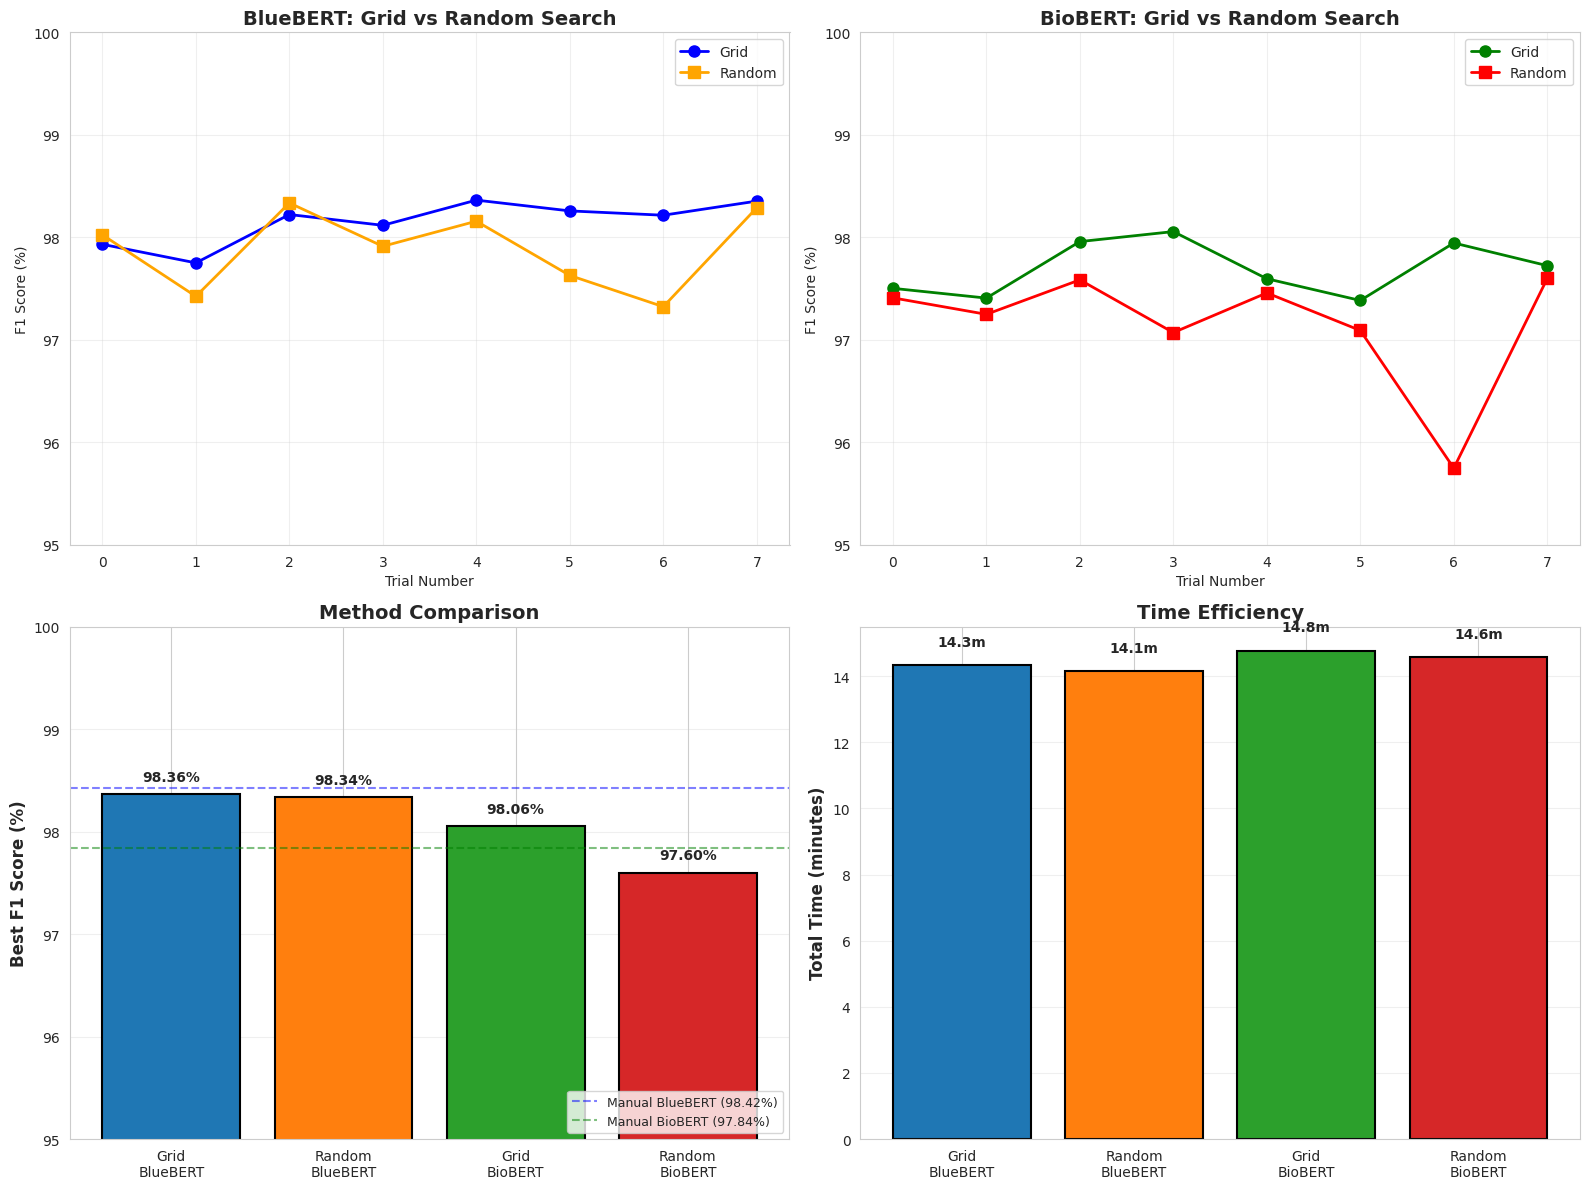

Visualizations saved: optimization_comparison.png | Cell 11 runtime: 2.02s


In [11]:
# CELL 11: Visualizations
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

cell_start = time.time()

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Convergence plots
axes[0, 0].plot([r["f1"] for r in grid_results_blue], 'o-', label='Grid', color='blue', linewidth=2, markersize=8)
axes[0, 0].plot([r["f1"] for r in random_results_blue], 's-', label='Random', color='orange', linewidth=2, markersize=8)
axes[0, 0].set_title('BlueBERT: Grid vs Random Search', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Trial Number')
axes[0, 0].set_ylabel('F1 Score (%)')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].set_ylim([95, 100])

axes[0, 1].plot([r["f1"] for r in grid_results_bio], 'o-', label='Grid', color='green', linewidth=2, markersize=8)
axes[0, 1].plot([r["f1"] for r in random_results_bio], 's-', label='Random', color='red', linewidth=2, markersize=8)
axes[0, 1].set_title('BioBERT: Grid vs Random Search', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Trial Number')
axes[0, 1].set_ylabel('F1 Score (%)')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].set_ylim([95, 100])

# Bar chart comparison
methods = [f"{r['Method']}\n{r['Model']}" for r in comparison_data]
f1_scores = [r['F1'] for r in comparison_data]
bars = axes[1, 0].bar(methods, f1_scores, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'],
                       edgecolor='black', linewidth=1.5)
axes[1, 0].axhline(y=98.42, color='blue', linestyle='--', alpha=0.5, label='Manual BlueBERT (98.42%)')
axes[1, 0].axhline(y=97.84, color='green', linestyle='--', alpha=0.5, label='Manual BioBERT (97.84%)')
axes[1, 0].set_ylabel('Best F1 Score (%)', fontsize=12, fontweight='bold')
axes[1, 0].set_title('Method Comparison', fontsize=14, fontweight='bold')
axes[1, 0].set_ylim([95, 100])
axes[1, 0].legend(loc='lower right', fontsize=9)
axes[1, 0].grid(True, axis='y', alpha=0.3)
for i, bar in enumerate(bars):
    height = bar.get_height()
    axes[1, 0].text(bar.get_x() + bar.get_width()/2., height + 0.1,
                    f'{height:.2f}%', ha='center', va='bottom', fontweight='bold')

# Time efficiency
times = [r['Time']/60 for r in comparison_data]
bars2 = axes[1, 1].bar(methods, times, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'],
                        edgecolor='black', linewidth=1.5)
axes[1, 1].set_ylabel('Total Time (minutes)', fontsize=12, fontweight='bold')
axes[1, 1].set_title('Time Efficiency', fontsize=14, fontweight='bold')
axes[1, 1].grid(True, axis='y', alpha=0.3)
for i, bar in enumerate(bars2):
    height = bar.get_height()
    axes[1, 1].text(bar.get_x() + bar.get_width()/2., height + 0.5,
                    f'{height:.1f}m', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig('optimization_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

cell_time = round(time.time() - cell_start, 2)
print(f"Visualizations saved: optimization_comparison.png | Cell 11 runtime: {cell_time}s")